In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV

from keras.models import Sequential
import keras.layers
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from catboost import Pool

# Ignore warnings, to keep notebook clean
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the Training and Testing Data
train = pd.read_csv('Dataset_Processed/train_processed.csv')
test = pd.read_csv('Dataset_Processed/test_processed.csv')

features = train.columns.values.tolist()
features.remove('Exited')
print(features)

# Splitting the training data into train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(train[features], train['Exited'], test_size=0.2, random_state=0) # 80% training and 20% test

['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure', 'AgeCategory', 'Sur_Geo_Gend_Sal', 'surname_tfidf_0', 'surname_tfidf_1', 'surname_tfidf_2', 'surname_tfidf_3', 'surname_tfidf_4', 'surname_tfidf_5', 'surname_tfidf_6', 'surname_tfidf_7', 'surname_tfidf_8', 'surname_tfidf_9']


In [3]:
# A function print the accuracy, log loss and auc for each model
def print_results(classifier_name, y_test, y_pred, y_pred_proba, fpr, tpr):
    print('Train/Test split results:')
    print(classifier_name + " accuracy is %2.3f" % metrics.accuracy_score(y_test, y_pred))
    print(classifier_name + " log_loss is %2.3f" % metrics.log_loss(y_test, y_pred_proba))
    print(classifier_name + " auc is %2.3f" % metrics.auc(fpr, tpr))

# A function to plot the ROC curve
def plot_roc_curve(fpr, tpr, classifier_name):
    idx = np.min(np.where(tpr > 0.95))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - Sensitivity]')
    plt.ylabel('True Positive Rate')
    plt.title(classifier_name + ' ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

results = []
# A function to save the accuracy, log loss and auc for each model
def save_accuracy(classifier_name, accuracy, log_loss, auc):
    results.append([classifier_name, accuracy, log_loss, auc])

# A function to plot a bar chart of the Accuracy, Log Loss and AUC for each model
def plot_results():
    df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Log Loss', 'AUC'])
    df_results = df_results.sort_values(by=['Accuracy'], ascending=False)
    df_results = df_results.reset_index(drop=True)
    scaler = MinMaxScaler()
    df_results['Log Loss'] = scaler.fit_transform(df_results['Log Loss'].values.reshape(-1, 1))
    df_results.rename(columns={'Log Loss': 'Log Loss (Normalized)'}, inplace=True)
    df_results.head()
    df_results_sorted = df_results.sort_values(by='AUC')    # Sort the DataFrame by AUC

    bar_width = 0.25
    pos = np.arange(len(df_results_sorted['Model']))
    plt.figure(figsize=(12, 6))
    plt.bar(pos, df_results_sorted['Accuracy'], color='steelblue', width=bar_width, label='Accuracy')
    plt.bar(pos + bar_width, df_results_sorted['Log Loss (Normalized)'], color='limegreen', width=bar_width, label='Log Loss (Normalized)')

    # Plot the AUC bars
    plt.bar(pos + 2*bar_width, df_results_sorted['AUC'], color='orange', width=bar_width, label='AUC')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance')
    plt.xticks(pos + bar_width, df_results_sorted['Model'], rotation=90)
    plt.ylim(0, 1)
    plt.legend()

    # Annotate the AUC values on the bars with rotation
    for i, auc in enumerate(df_results_sorted['AUC']):
        plt.annotate(f'{auc:.3f}',
                    xy=(pos[i] + 2*bar_width, auc),
                    xytext=(5, 5),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    rotation=90)

    plt.tight_layout()
    plt.show()

##### Non-Ensemble Methods

Train/Test split results:
Logistic Regression accuracy is 0.827
Logistic Regression log_loss is 0.399
Logistic Regression auc is 0.816


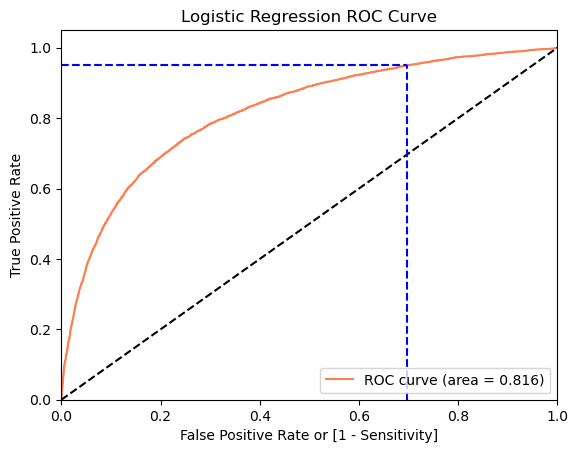

In [4]:
# Performing Logistic Regression & checking the accuracy using AUC ROC Curve with plots
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Logistic Regression", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Logistic Regression")
save_accuracy("Logistic Regression", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))


Train/Test split results:
Random Forest accuracy is 0.860
Random Forest log_loss is 0.334
Random Forest auc is 0.880


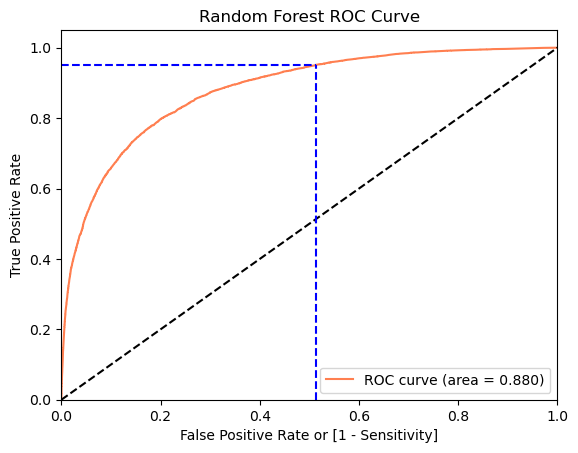

In [5]:
# Performing Random Forest & checking the accuracy using AUC ROC Curve with plots
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Random Forest", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Random Forest")
save_accuracy("Random Forest", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
Linear SVC accuracy is 0.804
Linear SVC log_loss is 6.818
Linear SVC auc is 0.809


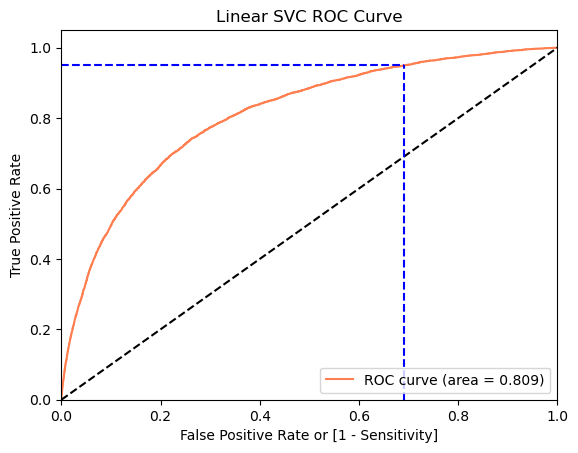

In [6]:
# Performing Linear SVC & checking the accuracy using AUC ROC Curve with plots
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)
y_pred_proba = lsvc.decision_function(X_test)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Linear SVC", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Linear SVC")
save_accuracy("Linear SVC", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
Decision Tree accuracy is 0.796
Decision Tree log_loss is 7.362
Decision Tree auc is 0.704


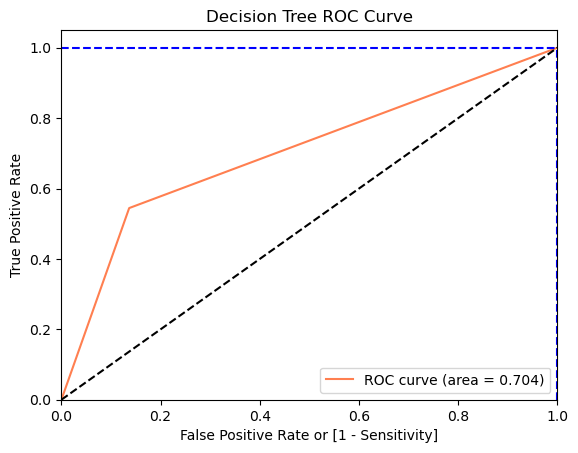

In [7]:
# Performing Decision Tree & checking the accuracy using AUC ROC Curve with plots
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Decision Tree", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Decision Tree")
save_accuracy("Decision Tree", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
KNeighborsClassifier accuracy is 0.835
KNeighborsClassifier log_loss is 1.648
KNeighborsClassifier auc is 0.813


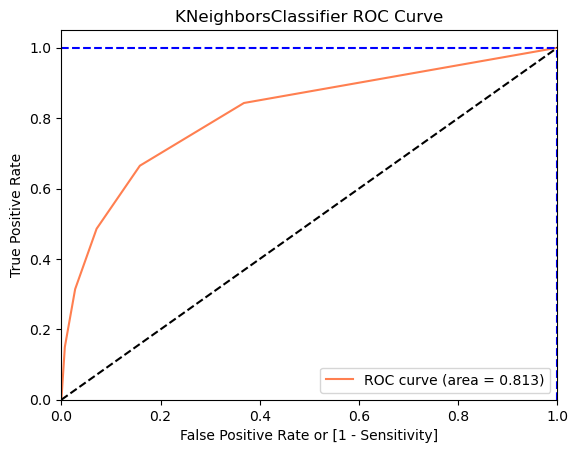

In [8]:
# Performing KNeighborsClassifier & checking the accuracy using AUC ROC Curve with plots
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

y_pred_proba = knn.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("KNeighborsClassifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "KNeighborsClassifier")
save_accuracy("KNeighborsClassifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
GaussianNB accuracy is 0.792
GaussianNB log_loss is 0.727
GaussianNB auc is 0.781


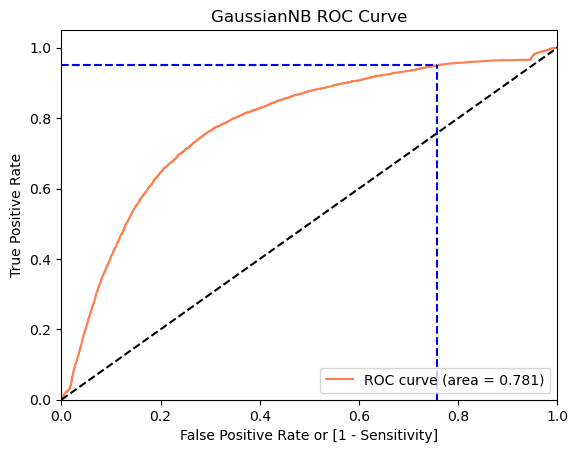

In [9]:
# Performing GaussianNB & checking the accuracy using AUC ROC Curve with plots
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_pred_proba = gnb.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("GaussianNB", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "GaussianNB")
save_accuracy("GaussianNB", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
LDA accuracy is 0.826
LDA log_loss is 0.399
LDA auc is 0.819


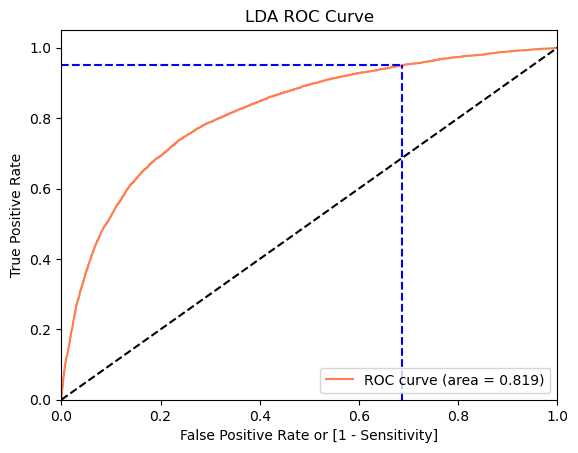

In [10]:
# Using LDA & checking the accuracy using AUC ROC Curve with plots
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
y_pred_proba = lda.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("LDA", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "LDA")
save_accuracy("LDA", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
QDA accuracy is 0.805
QDA log_loss is 0.670
QDA auc is 0.797


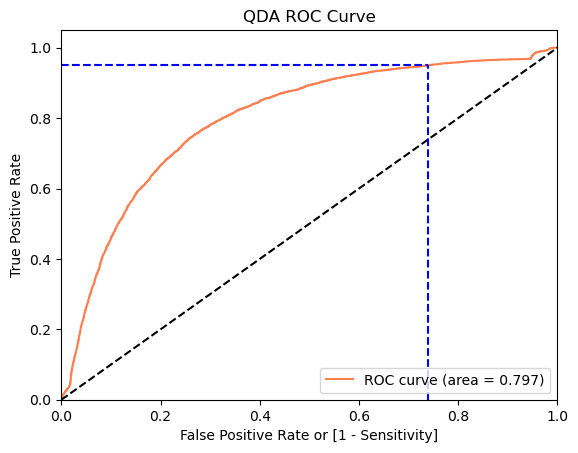

In [11]:
# Using QDA & checking the accuracy using AUC ROC Curve with plots
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
y_pred_proba = qda.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("QDA", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "QDA")
save_accuracy("QDA", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
Ridge Classifier accuracy is 0.821
Ridge Classifier log_loss is 5.703
Ridge Classifier auc is 0.819


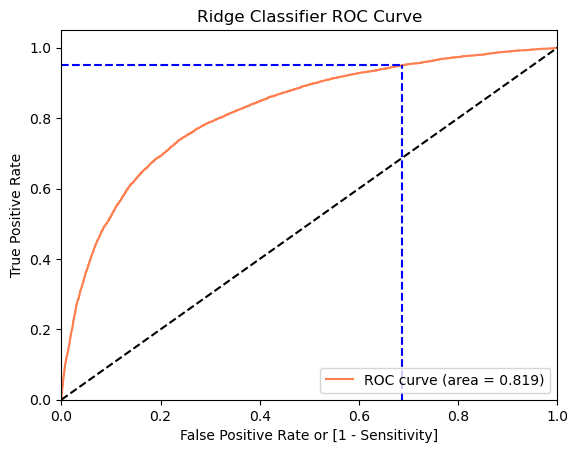

In [12]:
# Using Ridge Classifier & checking the accuracy using AUC ROC Curve with plots
rc = RidgeClassifier()
rc.fit(X_train, y_train)
y_pred = rc.predict(X_test)
y_pred_proba = rc.decision_function(X_test)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Ridge Classifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Ridge Classifier")
save_accuracy("Ridge Classifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
Perceptron accuracy is 0.802
Perceptron log_loss is 7.132
Perceptron auc is 0.746


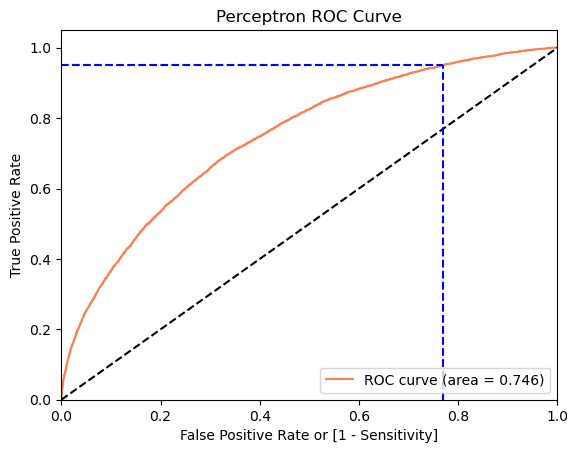

In [13]:
# Using Perceptron & checking the accuracy using AUC ROC Curve with plots
pc = Perceptron()
pc.fit(X_train, y_train)
y_pred = pc.predict(X_test)
y_pred_proba = pc.decision_function(X_test)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Perceptron", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Perceptron")
save_accuracy("Perceptron", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
Passive Aggressive Classifier accuracy is 0.795
Passive Aggressive Classifier log_loss is 7.313
Passive Aggressive Classifier auc is 0.751


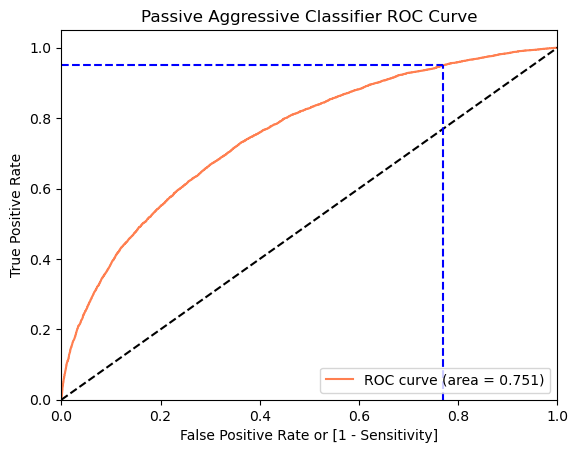

In [14]:
# Using Passive Aggressive Classifier & checking the accuracy using AUC ROC Curve with plots
pac = PassiveAggressiveClassifier()
pac.fit(X_train, y_train)
y_pred = pac.predict(X_test)
y_pred_proba = pac.decision_function(X_test)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Passive Aggressive Classifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Passive Aggressive Classifier")
save_accuracy("Passive Aggressive Classifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
SGD Classifier accuracy is 0.816
SGD Classifier log_loss is 6.203
SGD Classifier auc is 0.813


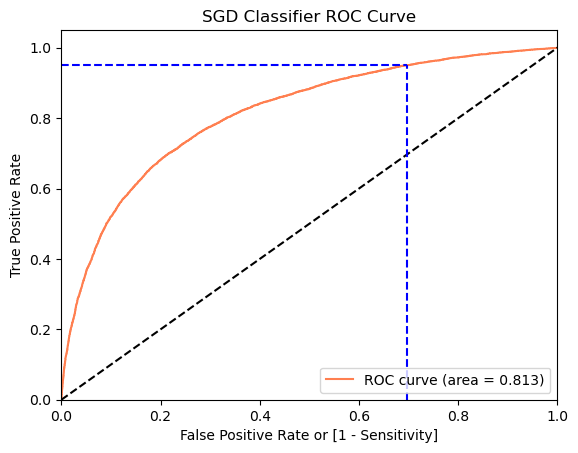

In [15]:
# Using Stochastic Gradient Descent Classifier & checking the accuracy using AUC ROC Curve with plots
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
y_pred_proba = sgd.decision_function(X_test)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("SGD Classifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "SGD Classifier")
save_accuracy("SGD Classifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
MLP accuracy is 0.862
MLP log_loss is 4.962
MLP auc is 0.742


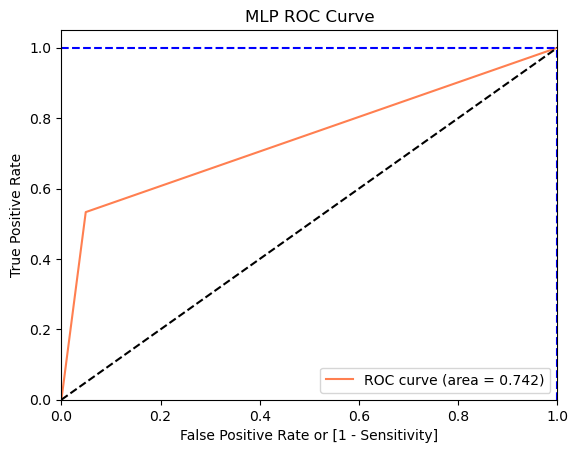

In [16]:
# Using Multilayer Perceptron (MLP) & checking the accuracy using AUC ROC Curve with plots
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict(X_test)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("MLP", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "MLP")
save_accuracy("MLP", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

##### Ensemble Models

Train/Test split results:
XGBoost accuracy is 0.863
XGBoost log_loss is 0.323
XGBoost auc is 0.888


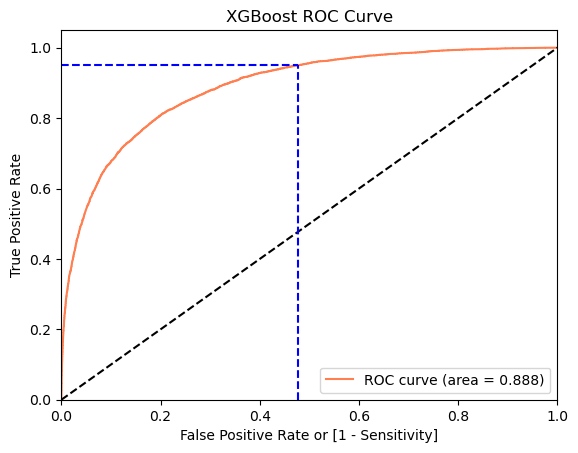

In [17]:
# Using XGBoost & checking the accuracy using AUC ROC Curve with plots
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("XGBoost", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "XGBoost")
save_accuracy("XGBoost", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

[LightGBM] [Info] Number of positive: 29539, number of negative: 110486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3866
[LightGBM] [Info] Number of data points in the train set: 140025, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210955 -> initscore=-1.319177
[LightGBM] [Info] Start training from score -1.319177
Train/Test split results:
LightGBM accuracy is 0.865
LightGBM log_loss is 0.317
LightGBM auc is 0.892


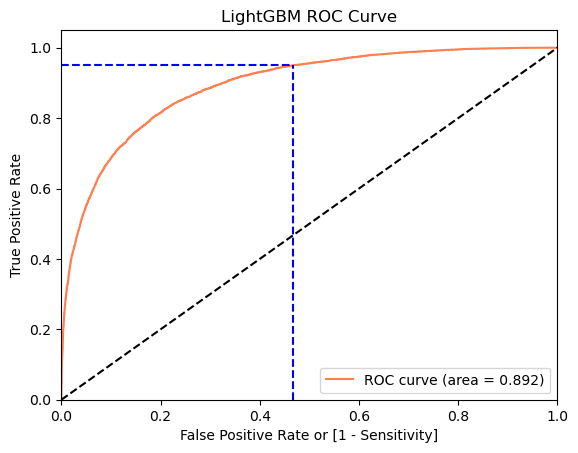

In [18]:
# Using LightGBM & checking the accuracy using AUC ROC Curve with plots
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
y_pred_proba = lgb.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("LightGBM", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "LightGBM")
save_accuracy("LightGBM", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

0:	total: 174ms	remaining: 10m 7s
1:	total: 201ms	remaining: 5m 50s
2:	total: 230ms	remaining: 4m 27s
3:	total: 261ms	remaining: 3m 48s
4:	total: 287ms	remaining: 3m 20s
5:	total: 314ms	remaining: 3m 3s
6:	total: 342ms	remaining: 2m 50s
7:	total: 367ms	remaining: 2m 40s
8:	total: 395ms	remaining: 2m 33s
9:	total: 425ms	remaining: 2m 28s
10:	total: 452ms	remaining: 2m 23s
11:	total: 485ms	remaining: 2m 20s
12:	total: 515ms	remaining: 2m 18s
13:	total: 545ms	remaining: 2m 15s
14:	total: 569ms	remaining: 2m 12s
15:	total: 605ms	remaining: 2m 11s
16:	total: 648ms	remaining: 2m 12s
17:	total: 692ms	remaining: 2m 13s
18:	total: 722ms	remaining: 2m 12s
19:	total: 748ms	remaining: 2m 10s
20:	total: 779ms	remaining: 2m 9s
21:	total: 805ms	remaining: 2m 7s
22:	total: 832ms	remaining: 2m 5s
23:	total: 861ms	remaining: 2m 4s
24:	total: 901ms	remaining: 2m 5s
25:	total: 942ms	remaining: 2m 5s
26:	total: 986ms	remaining: 2m 6s
27:	total: 1.02s	remaining: 2m 6s
28:	total: 1.05s	remaining: 2m 6s
29:	t

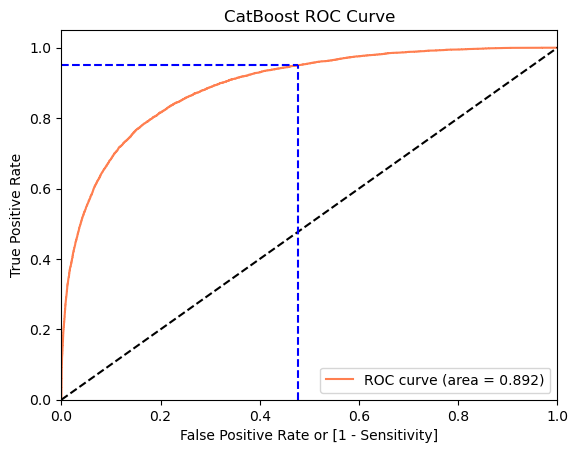

In [19]:
# Using CatBoost & checking the accuracy using AUC ROC Curve with plots
cat = CatBoostClassifier(eval_metric = 'AUC',learning_rate = 0.0025, iterations= 3500)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
y_pred_proba = cat.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("CatBoost", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "CatBoost")
save_accuracy("CatBoost", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
AdaBoost accuracy is 0.858
AdaBoost log_loss is 0.673
AdaBoost auc is 0.880


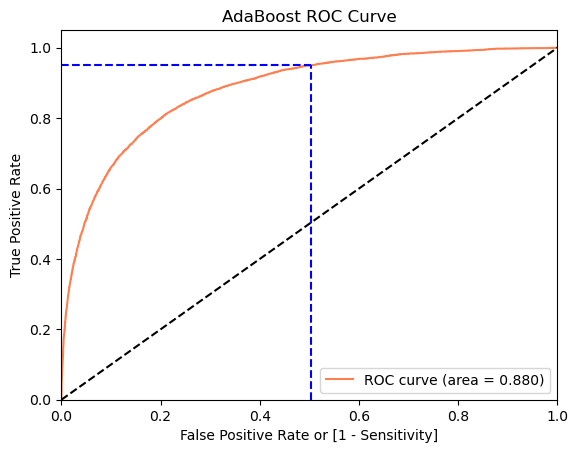

In [20]:
# Using AdaBoost & checking the accuracy using AUC ROC Curve with plots
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
y_pred_proba = ada.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("AdaBoost", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "AdaBoost")
save_accuracy("AdaBoost", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
ExtraTreesClassifier accuracy is 0.855
ExtraTreesClassifier log_loss is 0.391
ExtraTreesClassifier auc is 0.871


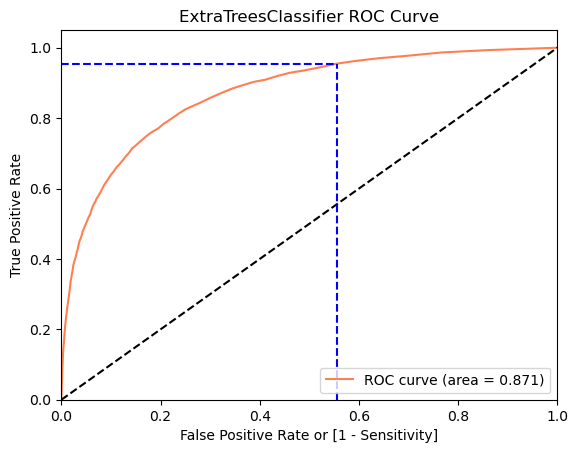

In [21]:
# Using ExtraTreesClassifier & checking the accuracy using AUC ROC Curve with plots
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)
y_pred_proba = etc.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("ExtraTreesClassifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "ExtraTreesClassifier")
save_accuracy("ExtraTreesClassifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

[LightGBM] [Info] Number of positive: 29539, number of negative: 110486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3866
[LightGBM] [Info] Number of data points in the train set: 140025, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210955 -> initscore=-1.319177
[LightGBM] [Info] Start training from score -1.319177
0:	total: 20.2ms	remaining: 1m 10s
1:	total: 40.7ms	remaining: 1m 11s
2:	total: 60.3ms	remaining: 1m 10s
3:	total: 79.3ms	remaining: 1m 9s
4:	total: 96.9ms	remaining: 1m 7s
5:	total: 118ms	remaining: 1m 8s
6:	total: 136ms	remaining: 1m 8s
7:	total: 157ms	remaining: 1m 8s
8:	total: 177ms	remaining: 1m 8s
9:	total: 194ms	remaining: 1m 7s
10:	total: 211ms	remaining: 1m 6s
11:	total: 232ms	remaining: 1m 7s
12:	total: 261ms	remaining: 1m 9s


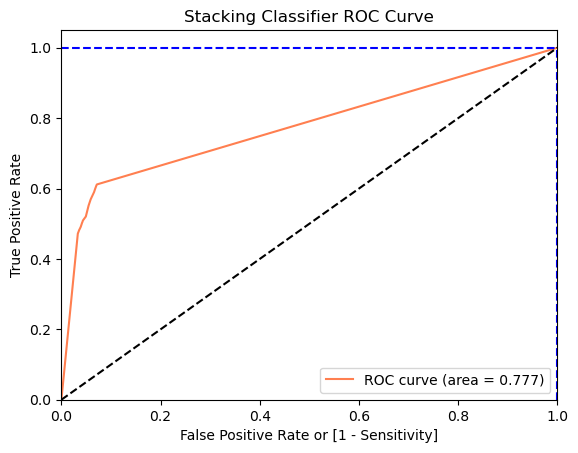

In [22]:
# Using Stacking Classifier & checking the accuracy using AUC ROC Curve with plots
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[rf, lgb, xgb, cat], meta_classifier=lr)
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)
y_pred_proba = sclf.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Stacking Classifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Stacking Classifier")
save_accuracy("Stacking Classifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
Gradient Boosting Classifier accuracy is 0.863
Gradient Boosting Classifier log_loss is 0.322
Gradient Boosting Classifier auc is 0.889


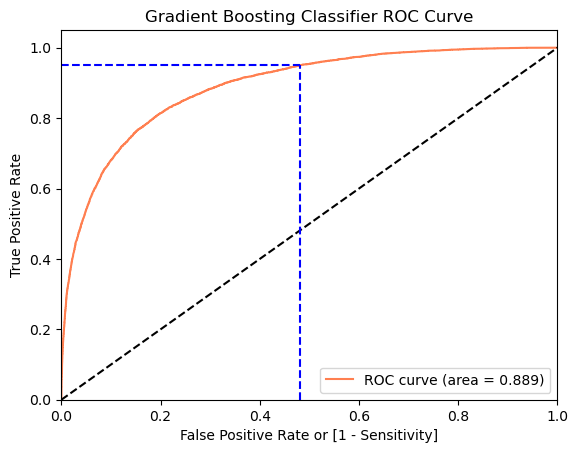

In [23]:
# Using Gradient Boosting Classifier & checking the accuracy using AUC ROC Curve with plots
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Gradient Boosting Classifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Gradient Boosting Classifier")
save_accuracy("Gradient Boosting Classifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

Train/Test split results:
Bagging Classifier accuracy is 0.849
Bagging Classifier log_loss is 0.997
Bagging Classifier auc is 0.847


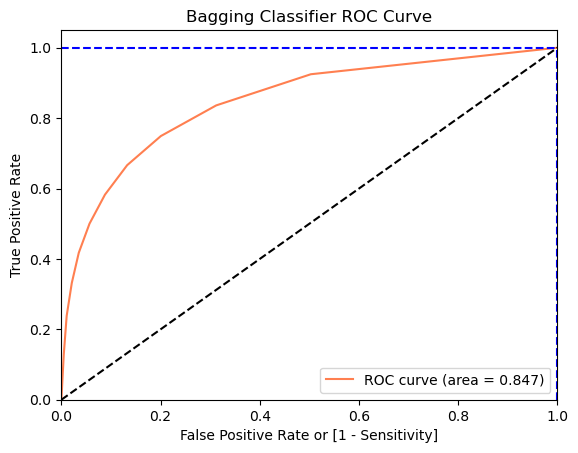

In [24]:
# Using Bagging Classifier & checking the accuracy using AUC ROC Curve with plots
bc = BaggingClassifier()
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
y_pred_proba = bc.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Bagging Classifier", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Bagging Classifier")
save_accuracy("Bagging Classifier", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

##### Neural Network

Epoch 1/250
4376/4376 [==============================] - 38s 8ms/step - loss: 0.3883 - accuracy: 0.8371 - val_loss: 0.3434 - val_accuracy: 0.8538
Epoch 2/250
4376/4376 [==============================] - 40s 9ms/step - loss: 0.3352 - accuracy: 0.8597 - val_loss: 0.3339 - val_accuracy: 0.8589
Epoch 3/250
4376/4376 [==============================] - 44s 10ms/step - loss: 0.3288 - accuracy: 0.8625 - val_loss: 0.3308 - val_accuracy: 0.8599
Epoch 4/250
4376/4376 [==============================] - 40s 9ms/step - loss: 0.3253 - accuracy: 0.8639 - val_loss: 0.3274 - val_accuracy: 0.8617
Epoch 5/250
4376/4376 [==============================] - 44s 10ms/step - loss: 0.3227 - accuracy: 0.8650 - val_loss: 0.3264 - val_accuracy: 0.8613
Epoch 6/250
4376/4376 [==============================] - 40s 9ms/step - loss: 0.3206 - accuracy: 0.8660 - val_loss: 0.3283 - val_accuracy: 0.8610
Epoch 7/250
4376/4376 [==============================] - 38s 9ms/step - loss: 0.3191 - accuracy: 0.8668 - val_loss: 0.3251

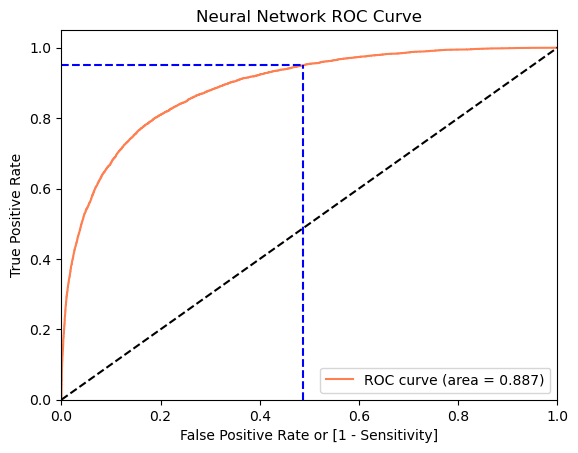

In [25]:
# Using a Neural Network with Early Stopping & checking the accuracy using AUC ROC Curve with plots
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(X_train))
input_dim =  X_train.shape[1]

model = Sequential([
    normalizer,
    Dense(1024, activation='relu', input_shape=(input_dim,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate = 0.00001), loss = 'binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience = 20, mode = 'min', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 250, batch_size = 32, callbacks=[early_stopping])

# Predictions
y_pred_proba = model.predict(X_test).ravel()  # Model's output is probabilities
y_pred = (y_pred_proba > 0.5).astype('int32')  # Convert probabilities to binary labels
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)

print_results("Neural Network", y_test, y_pred, y_pred_proba, fpr, tpr)
plot_roc_curve(fpr, tpr, "Neural Network")
save_accuracy("Neural Network", metrics.accuracy_score(y_test, y_pred), metrics.log_loss(y_test, y_pred_proba), metrics.auc(fpr, tpr))

##### Plotting Results (To review which model to work upon further)

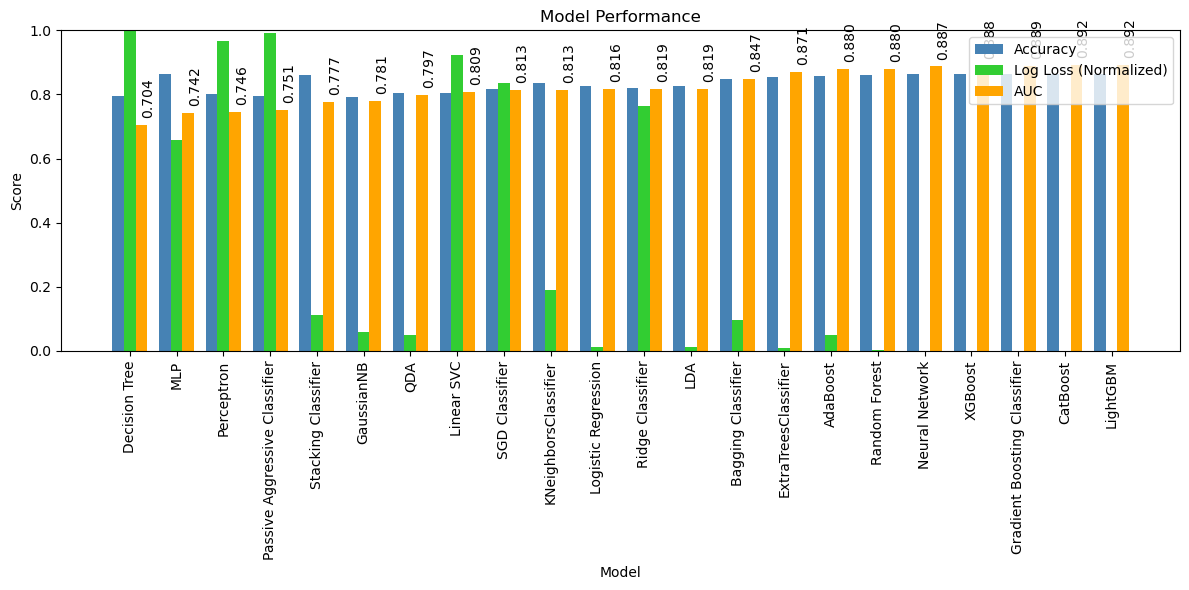

In [26]:
plot_results()

##### CatBoost (On Processed Data)

As the Catboost seems to have the highest score on the test file (via Kaggle Public Score), let us work on that.  

*Note: We will use the original train/test files as Catboost can handle categorical data.*

In [28]:
num_folds = 10
num_est = 5500

train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

scale_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

def scale_data(train, test, column):
    scaler = MinMaxScaler()
    max_value = max(train[column].values.max(), test[column].values.max())
    min_value = min(train[column].values.min(), test[column].values.min())

    train[column] = (train[column] - min_value)/(max_value - min_value)
    test[column] = (test[column] - min_value)/(max_value - min_value)

    return train, test

for column in scale_columns:
    train, test = scale_data(train, test, column)

def FeatureExtraction(df): 
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCategory'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    return df

train = FeatureExtraction(train)
test = FeatureExtraction(test)

features = ['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age',
       'CreditScore', 'Balance', 'EstimatedSalary',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure', 'AgeCategory',
       'Sur_Geo_Gend_Sal']

X = train[features]
y = train['Exited']

cat_features = np.where(X.dtypes != np.float64)[0]

folds = StratifiedKFold(n_splits=num_folds,shuffle=True)
test_preds = np.empty((num_folds, len(test)))
auc_vals=[]

for n_fold, (train_i, valid_i) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_i], y.iloc[train_i]
    X_val, y_val = X.iloc[valid_i], y.iloc[valid_i]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.020,
    iterations = num_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[features])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(test[features])[:,1]
    test_preds[n_fold, :] = y_pred_test

0:	test: 0.8767050	best: 0.8767050 (0)	total: 194ms	remaining: 17m 47s
300:	test: 0.8963298	best: 0.8963298 (300)	total: 56.8s	remaining: 16m 20s
600:	test: 0.8982185	best: 0.8982185 (600)	total: 1m 57s	remaining: 16m
900:	test: 0.8990990	best: 0.8991012 (896)	total: 2m 58s	remaining: 15m 8s
1200:	test: 0.8993100	best: 0.8993100 (1200)	total: 4m	remaining: 14m 21s
1500:	test: 0.8995009	best: 0.8995009 (1500)	total: 5m 4s	remaining: 13m 31s
1800:	test: 0.8995470	best: 0.8995527 (1762)	total: 6m 5s	remaining: 12m 30s
2100:	test: 0.8995919	best: 0.8995944 (2099)	total: 7m 10s	remaining: 11m 35s
2400:	test: 0.8996597	best: 0.8996722 (2387)	total: 8m 12s	remaining: 10m 35s
2700:	test: 0.8996662	best: 0.8996778 (2612)	total: 9m 11s	remaining: 9m 31s
3000:	test: 0.8997063	best: 0.8997272 (2965)	total: 10m 8s	remaining: 8m 26s
3300:	test: 0.8996878	best: 0.8997307 (3060)	total: 11m 8s	remaining: 7m 25s
3600:	test: 0.8996513	best: 0.8997307 (3060)	total: 12m 7s	remaining: 6m 23s
3900:	test: 0.8

Adding ~ 0.002 to your LB score (Exploit), https://www.kaggle.com/competitions/playground-series-s4e1/discussion/469859#2617720

In [29]:
y_pred = test_preds.mean(axis=0)
df_orig=pd.read_csv("Dataset/original.csv")

join_cols=list(df_orig.columns.drop(['RowNumber','Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})

df_test_ov = test.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
df_sub = df_test_ov[['id','Exited_Orig']]

df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
df_sub.drop('Exited_Orig',axis=1,inplace=True)

In [30]:
# Saving the predictions to a csv file
df_sub.to_csv('submission.csv', index=False)